In [26]:
import pandas as pd
import numpy as np
import zarr
import dask.array as da
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import napari
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from track_gardener.db.db_model import CellDB, TrackDB

In [2]:
# get access to the database
db_path = r'R:\\Yian\Time-lapse\Triple_analysis\E2Control\E2_data_gardener.db'
engine = create_engine(f'sqlite:///{db_path}')
session = sessionmaker(bind=engine)()

In [28]:
ch00_path = r'R:\\Yian\Time-lapse\Triple_analysis\E2Control\E2_ch00.zarr'
ch01_path = r'R:\\Yian\Time-lapse\Triple_analysis\E2Control\E2_ch01.zarr'
ch02_path = r'R:\\Yian\Time-lapse\Triple_analysis\E2Control\E2_ch02.zarr'

frame_interval = 15

## Cell data

In [29]:
t=session.query(CellDB).filter(CellDB.track_id == 179).order_by(CellDB.t).all()

In [32]:
columns = [col.name for col in CellDB.__table__.columns]
records = [{col: getattr(row, col) for col in columns} for row in t]
df = pd.DataFrame(records)

# Expand the 'signals' column into separate columns
signals_expanded = pd.json_normalize(df['signals'])
# Combine back with the rest of the DataFrame
df = pd.concat([df.drop(columns=['signals']), signals_expanded], axis=1)

df['ch2_ratio'] = df['ch2_cyto'] / df['ch2_nuc']
df['ch1_ratio'] = df['ch1_cyto'] / df['ch1_nuc']

df['cell_t'] = (df['t'] - df['t'].min())*frame_interval/60

In [41]:
df

,track_id,t,id,row,col,bbox_0,bbox_1,bbox_2,bbox_3,mask,...,area,ch0_nuc,ch0_cyto,ch1_nuc,ch1_cyto,ch2_nuc,ch2_cyto,ch2_ratio,ch1_ratio,cell_t
0,179,21,179,1946,3989,1925,3968,1970,4011,"[[False, False, False, False, False, False, Fa...",...,1581,954.688172,700.165228,280.630614,205.061652,623.126502,384.229346,0.616615,0.730717,0.00
1,179,22,179,1930,3986,1912,3964,1950,4009,"[[False, False, False, False, False, False, Fa...",...,1001,1061.888112,763.359633,264.365634,233.077064,597.496503,464.735780,0.777805,0.881647,0.25
2,179,23,179,1921,3969,1909,3948,1938,3991,"[[False, False, False, False, False, False, Fa...",...,883,1222.389581,765.000000,235.100793,241.412564,583.517554,479.599321,0.821911,1.026847,0.50
3,179,24,179,1935,3980,1920,3958,1952,4004,"[[False, False, False, False, False, False, Fa...",...,1303,978.934766,650.879288,171.353031,185.454892,386.801995,325.247776,0.840864,1.082297,0.75
4,179,25,179,1953,3993,1933,3975,1974,4014,"[[False, False, False, False, False, False, Fa...",...,1387,1018.509012,581.966963,173.309301,177.891995,399.808219,281.395172,0.703825,1.026442,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,179,113,114000113,2456,3942,2422,3908,2491,3976,"[[False, False, False, False, False, False, Fa...",...,3679,1414.076379,542.062607,172.493341,227.362779,254.032346,432.658662,1.703164,1.318096,23.00
93,179,114,115000105,2458,3944,2424,3910,2493,3977,"[[False, False, False, False, False, False, Fa...",...,3659,1433.699371,546.733788,176.830828,235.723549,278.602624,467.222696,1.677022,1.333046,23.25
94,179,115,179,2458,3944,2420,3864,2522,3976,"[[True, True, False, False, False, False, Fals...",...,3069,1365.184099,748.054400,302.087325,257.467200,688.552949,542.220800,0.787479,0.852294,23.50
95,179,116,179,2456,3945,2404,3897,2512,3984,"[[False, False, False, False, False, False, Fa...",...,6193,1083.085096,561.444853,321.383175,156.787500,760.843210,195.964706,0.257563,0.487852,23.75


## Cell images

In [16]:
z = zarr.open_group(ch00_path, mode='r')
ch0 = da.from_zarr(z[0])

z = zarr.open_group(ch01_path, mode='r')
ch1 = da.from_zarr(z[0])

z = zarr.open_group(ch02_path, mode='r')
ch2 = da.from_zarr(z[0])

In [17]:
ch0

dask.array<from-zarr, shape=(481, 7550, 7549), dtype=uint16, chunksize=(1, 512, 512), chunktype=numpy.ndarray>

In [36]:
im_size = 120

cell_list_00 = []
cell_list_01 = []
cell_list_02 = []
for i,row in df.iterrows():
    
    cell = ch0[row.t,row.row-im_size//2:row.row+im_size//2,row.col-im_size//2:row.col+im_size//2].compute()
    cell_list_00.append(cell)

    cell = ch1[row.t,row.row-im_size//2:row.row+im_size//2,row.col-im_size//2:row.col+im_size//2].compute()
    cell_list_01.append(cell)

    cell = ch2[row.t,row.row-im_size//2:row.row+im_size//2,row.col-im_size//2:row.col+im_size//2].compute()
    cell_list_02.append(cell)

# put cell in the numpy array
images_00 = np.array(cell_list_00)
images_01 = np.array(cell_list_01)
images_02 = np.array(cell_list_02)

## Calculate PCNA signal

In [ ]:
max_height = 120
max_width = 120

def pad_and_center_mask(mask, max_height, max_width):
    h, w = mask.shape
    pad_height = max_height - h
    pad_width = max_width - w
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    return np.pad(mask, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=False)
    
# Apply padding
df['mask_padded'] = df['mask'].apply(lambda x: pad_and_center_mask(x, max_height, max_width))

masks_3d = np.stack(df['mask_padded'].values)
print(masks_3d.shape)  # (N, max_height, max_width)

In [63]:
from skimage.filters import difference_of_gaussians
from skimage.measure import regionprops, label

In [91]:
sigma1 = 2
sigma2 = 5

# Apply DoG to each frame
dog_stack = np.stack([
    difference_of_gaussians(frame.astype(float), sigma1, sigma2)
    for frame in images_00
])

dog_stack[dog_stack < 0] = 0  # Ensure no negative values

In [127]:
def st_dev(mask,im):
    med = np.median(im[mask])
    im[im<med] = med
    return np.std(im[mask]) + np.max(im[mask])/np.mean(im[mask])


pcna_signal = []
for f in range(dog_stack.shape[0]):

    res = regionprops(masks_3d[f].astype(int), intensity_image=dog_stack[f], extra_properties=[st_dev])
    pcna_signal.append(res[0]['st_dev'])

edge = 4
window = 10
start = np.min(pcna_signal[edge:window+edge])
end = np.min(pcna_signal[-window-edge:-edge])

trend = np.linspace(start, end, len(pcna_signal))
detrended = pcna_signal - trend

# normalize
core = detrended[edge : -edge]
core_min = np.min(core)
core_max = np.max(core)

detrended_norm = (detrended - core_min) / (core_max - core_min)

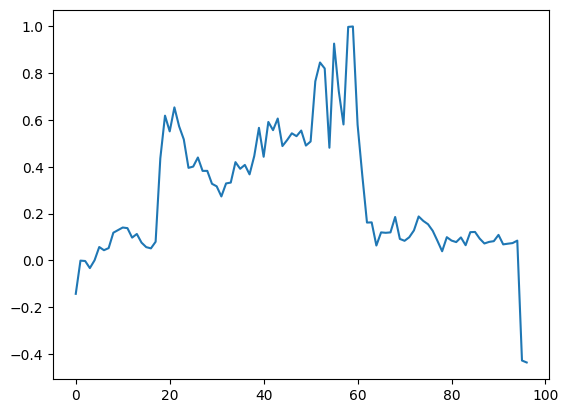

In [129]:
plt.plot(detrended_norm)

## Create the figure

In [23]:
np.max(images_02), np.min(images_02)

(np.uint16(1352), np.uint16(87))

In [135]:
signal1 = detrended_norm + 0.7
signal2 = df.ch1_ratio.values
signal3 = df.ch2_ratio.values
t = df.cell_t.values

N = images_00.shape[0]   # number of frames

# Set up the grid
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 3, height_ratios=[0.4, 0.6])

# Top row: 3 image axes
ax_img1 = fig.add_subplot(gs[0, 0])
ax_img2 = fig.add_subplot(gs[0, 1])
ax_img3 = fig.add_subplot(gs[0, 2])

# Bottom row: 1 graph spanning all 3 columns
ax_graph = fig.add_subplot(gs[1, :])

img_disp1 = ax_img1.imshow(images_00[0], cmap='bone_r', vmin=300, vmax=3500)
ax_img1.set_title('PCNA', fontsize=18)
img_disp2 = ax_img2.imshow(images_01[0], cmap='Purples', vmin=100, vmax=400)
ax_img2.set_title('CDK 4', fontsize=18)
img_disp3 = ax_img3.imshow(images_02[0], cmap='Greens', vmin=100, vmax=1000)
ax_img3.set_title('CDK 2', fontsize=18)


# Set black facecolor for image axes (background)
for ax in [ax_img1, ax_img2, ax_img3]:
    ax.set_facecolor('black')
    ax.set_xticks([])
    ax.set_yticks([])
    # Add a black border rectangle
    ax.add_patch(Rectangle((0, 0), 1, 1,
        transform=ax.transAxes,
        linewidth=4, edgecolor='black', facecolor='none', zorder=10))

# Graph: initialize empty lines for all 3 signals
line1, = ax_graph.plot([], [], 'black', label='PCNA var', lw=2, alpha = 0.7)
line2, = ax_graph.plot([], [], 'purple', label='CDK4', lw=2)
line3, = ax_graph.plot([], [], 'green', label='CDK2', lw=2)
ax_graph.set_xlim(0, t[-1])
ax_graph.set_ylim(0.4,1.8)

ax_graph.set_xlabel('Time [hours]', fontsize=18)
ax_graph.set_ylabel('Signals [a.u.]', fontsize=18)
ax_graph.legend(loc='upper left', fontsize=15)

# === Tight layout and margin adjustment ===
fig.tight_layout(pad=0.3)

def update(frame):
    # Update images
    img_disp1.set_data(images_00[frame])
    img_disp2.set_data(images_01[frame])
    img_disp3.set_data(images_02[frame])
    # Update lines
    line1.set_data(t[:frame+1], signal1[:frame+1])
    line2.set_data(t[:frame+1], signal2[:frame+1])
    line3.set_data(t[:frame+1], signal3[:frame+1])
    return img_disp1, img_disp2, img_disp3, line1, line2, line3

ani = FuncAnimation(fig, update, frames=N, blit=True)

# Save as MP4 (recommended for PowerPoint)
writer = FFMpegWriter(fps=10, metadata=dict(artist='Your Name'), bitrate=1800)
ani.save('cell_signal_movie.mp4', writer=writer)

#ani.save('cell_signal_movie.gif', writer='imagemagick', fps=10)

plt.close(fig)